In [30]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

# NOTE: change to your own path when setting workspace
ws = r'C:\Users\sgartrel\Desktop\geog490\final-proj\RainfallCollection\data'


### Step 1: Get Microsoft Building Footprint Data

The data needs to be broken into a subset, even smaller than the United States--no need for 129 million buildings in a massive geojson. Instead, we have to parse the quadkeys (an indexing technique used in vector tiling) into lat/long. For this, we will use the `mercantile` package.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Mercantile Documentation](https://mercantile.readthedocs.io/_/downloads/en/latest/pdf/)

In [31]:
# get state bounds
state = 'arizona'
state_df = gpd.read_file(f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/arizona.geojson')
state_geo = gpd.GeoDataFrame(state_df, crs=4326)

xmin, ymin, xmax, ymax = state_geo.total_bounds

state_bounds = Polygon([
        (xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)
    ])




In [54]:
location = 'United States'
bounds = state_bounds

dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
target_links = dataset_links[dataset_links.Location == location]
quadkeys = []

# find relevant tiles
for _, row in target_links.iterrows():
    # convert quadkey to mercantile.LngLatBbox
    key = str(row.QuadKey)
    tile = m.quadkey_to_tile(key)
    tile_geom = m.bounds(tile)

    # get bounding geometry from the mercantile obj
    xmin, ymin, xmax, ymax = tile_geom.west, tile_geom.south, tile_geom.east, tile_geom.north
    tile_bounds = Polygon([
            (xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)
        ])

    # perform intersection, keep intersecting features
    if bounds.intersects(tile_bounds):
        
        quadkeys.append(key) #TODO: not working yet

# for _, row in target_links.iterrows():
#     df = pd.read_json(row.Url, lines=True)
#     df = df['geometry'].apply(shape)
#     gdf = gpd.GeoDataFrame(df, crs=4326)
#     if gdf.intersects(bounds).any():
#         gdf.to_file(f"{row.QuadKey}.geojson", driver="GeoJSON")
#     else:
#         gdf = None # remove final gdf from memory 

In [50]:
quadkeys

[]

In [8]:
# load precip data
xds = xr.open_dataset('precip.nc')

# check info
xds.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:    (longitude: 29, latitude: 27, expver: 2, time: 120)
Coordinates:
  * longitude  (longitude) float32 -115.0 -114.8 -114.5 ... -108.5 -108.2 -108.0
  * latitude   (latitude) float32 37.5 37.25 37.0 36.75 ... 31.5 31.25 31.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2022-12-01
Data variables:
    tp         (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-16 19:00:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>

TypeError: Invalid shape (2, 27, 29) for image data

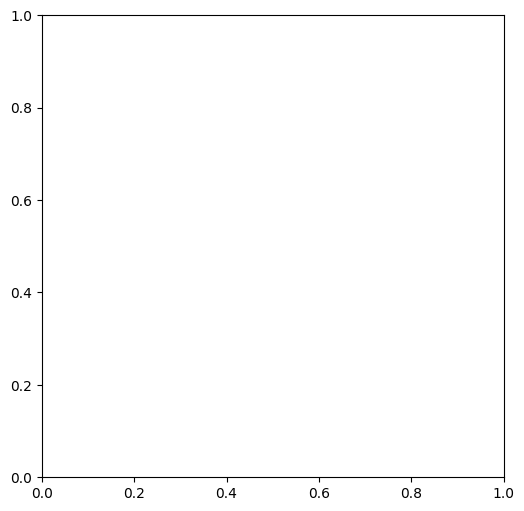

In [26]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))

im1 = ax.imshow(xds['tp'][0:], cmap='RdYlBu_r')
ax.scatter(100, 300, s=100, c='k')

ax.set_title("Air temperature", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [35]:
tp = xds['tp'].to_dataframe()
tp

tp
time       expver latitude longitude          
2013-01-01 1      37.5     -115.00    0.000332
                           -114.75    0.000429
                           -114.50    0.000551
                           -114.25    0.000633
                           -114.00    0.000626
...                                        ...
2022-12-01 5      31.0     -109.00    0.000721
                           -108.75    0.000685
                           -108.50    0.000290
                           -108.25    0.000233
                           -108.00    0.000227

[187920 rows x 1 columns]

In [37]:
tp.iloc[0]

tp    0.000332
Name: (2013-01-01 00:00:00, 1, 37.5, -115.0), dtype: float32